# Caustics

In [1]:
figpath = '2022-12-04_caustique'

In [2]:
PRECISION = 4 # the higher, the bigger the file

In [3]:
PRECISION = 10 # the higher, the bigger the file

In [4]:
import os
import datetime
import numpy as np

# https://docs.python.org/3/library/dataclasses.html?highlight=dataclass#module-dataclasses
from dataclasses import dataclass, asdict, field

@dataclass
class init:
    figpath: str = figpath # Folder to store images
    phi: float = 1.61803 # beauty is gold
    tag: str = 'caustique' # Tag
    ext: str = 'png' # Extension for output
    nx: int = 5*2**PRECISION # number of pixels (vertical)
    ny: int = 5*2**PRECISION # number of pixels (horizontal)
    nframe: int = 1 # number of frames
    bin_dens: int = 2 # relative bin density
    bin_spectrum: int = 3 # bin spacing in spectrum
    seed: int = 1998 # seed for RNG
    H: float = 10.0 # depth of the pool
    variation: float = .20 # variation of diffraction index: http://www.philiplaven.com/p20.html 1.40 at 400 nm and 1.37 at 700nm makes a 2% variation
    scale: float = .75*2**PRECISION # period in pixels
    B_sf: float = 0.5 # bandwidth in sf
    V_Y: float = 0.3 # horizontal speed
    V_X: float = 0.3 # vertical speed
    B_V: float = 1.0 # bandwidth in speed
    theta: float = 2*np.pi*(2-1.61803) # angle with the horizontal
    B_theta: float = 30*np.pi/180 # bandwidth in theta
    min_lum: float = .1 # diffusion level for the rendering
    gamma: float = 2.8 # Gamma exponant to convert luminosity to luminance
    fps: float = 18 # frames per second
    multispectral: bool = True # Compute caustics on the full spectrogram.
    cache: bool = True # Cache intermediate output.
    verbose: bool = False # Displays more verbose output.
    do_display: bool = False # Displays images in notebook.
    do_recompute: bool = False # Restart each computation    

In [5]:
print(f'Saving our simulations in={figpath}')

Saving our simulations in=2022-12-04_caustique


In [6]:
opt = init()
opt.figpath = figpath

In [7]:
opt

init(figpath='2022-12-04_caustique', phi=1.61803, tag='caustique', ext='png', nx=5120, ny=5120, nframe=1, bin_dens=2, bin_spectrum=3, seed=1998, H=10.0, variation=0.2, scale=768.0, B_sf=0.5, V_Y=0.3, V_X=0.3, B_V=1.0, theta=2.399988291783386, B_theta=0.5235987755982988, min_lum=0.1, gamma=2.8, fps=18, multispectral=True, cache=True, verbose=False, do_display=False, do_recompute=False)

In [8]:
if opt.nframe==1: opt.ext = 'png'

## utilities

Transfoming a sequence of PNG frames into gif or mp4:

In [9]:
def make_gif(gifname, fnames, fps, do_delete=True):
    import imageio

    with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
        for fname in fnames:
            writer.append_data(imageio.imread(fname))

    from pygifsicle import optimize
    optimize(str(gifname))
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return gifname

# https://moviepy.readthedocs.io/en/latest/getting_started/videoclips.html#imagesequenceclip
def make_mp4(mp4name, fnames, fps, do_delete=True):
    import moviepy.editor as mpy
    clip = mpy.ImageSequenceClip(fnames, fps=fps)
    clip.write_videofile(mp4name, fps=fps, codec='libx264', verbose=False, logger=None)
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return mp4name


Utilities to compute the spectrum of the blue sky and convert them later to RGB values (check out https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for details)

In [10]:
from lambda2color import Lambda2color, xyz_from_xy

# borrowed from https://github.com/gummiks/gummiks.github.io/blob/master/scripts/astro/planck.py
def planck(wav, T):
    import scipy.constants as const
    c = const.c # c = 3.0e+8
    h = const.h # h = 6.626e-34
    k = const.k # k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def scattering(wav, a=0.005, p=1.3, b=0.45):
    """
    b is  proportionate  to  the  column  density  of  aerosols
    along  the  path  of  sunlight,  from  outside  the  atmosphere
    to  the  point  of  observation
    
    see https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for more details

    """
    # converting wav in µm:
    intensity = np.exp(-a/((wav/1e-6)**4)) # Rayleigh extinction by nitrogen
    intensity *= (wav/1e-6)**-4
    intensity *= np.exp(-b/((wav/1e-6)**p)) # Aerosols
    return intensity

## computing the caustics

In [11]:
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import shutil
import hashlib
import MotionClouds as mc

class Caustique:
    def __init__(self, opt):
        """
        Image coordinates follow 'ij' indexing, that is,
        * their origin at the top left,
        * the X axis is vertical and goes "down",
        * the Y axis is horizontal and goes "right".

        """
        self.mc = mc
        self.ratio = opt.ny/opt.nx # ratio between height and width (>1 for portrait, <1 for landscape)
        X = np.linspace(0, 1, opt.nx, endpoint=False) # vertical
        Y = np.linspace(0, self.ratio, opt.ny, endpoint=False) # horizontal
        self.xv, self.yv = np.meshgrid(X, Y, indexing='ij')
        self.opt = opt
        # https://stackoverflow.com/questions/16878315/what-is-the-right-way-to-treat-python-argparse-namespace-as-a-dictionary
        self.d = vars(opt)
        os.makedirs(self.opt.figpath, exist_ok=True)
        self.cachepath = os.path.join('/tmp', self.opt.figpath)
        if opt.verbose: print(f'{self.cachepath=}')
        os.makedirs(self.cachepath, exist_ok=True)

        # a standard white:
        illuminant_D65 = xyz_from_xy(0.3127, 0.3291), 
        illuminant_sun = xyz_from_xy(0.325998, 0.335354)
        # color conversion class
        self.cs_srgb = Lambda2color(red=xyz_from_xy(0.64, 0.33),
                               green=xyz_from_xy(0.30, 0.60),
                               blue=xyz_from_xy(0.15, 0.06),
                               white=illuminant_sun)
        self.wavelengths = self.cs_srgb.cmf[:, 0]*1e-9
        self.N_wavelengths = len(self.wavelengths)
        # multiply by the spectrum of the sky
        intensity5800 = planck(self.wavelengths, 5800.)
        scatter = scattering(self.wavelengths)
        self.spectrum_sky = intensity5800 * scatter
        self.spectrum_sky /= self.spectrum_sky.max()

    def wave(self):
        filename = f'{self.cachepath}/{self.opt.tag}_wave.npy'
        if os.path.isfile(filename) and not(self.opt.do_recompute):
            z = np.load(filename)
        else:
            # A simplistic model of a wave using https://github.com/NeuralEnsemble/MotionClouds
            fx, fy, ft = mc.get_grids(self.opt.nx, self.opt.ny, self.opt.nframe)
            env = mc.envelope_gabor(fx, fy, ft, V_X=self.opt.V_Y, V_Y=self.opt.V_X, B_V=self.opt.B_V,
                                    sf_0=1./self.opt.scale, B_sf=self.opt.B_sf/self.opt.scale,
                                    theta=self.opt.theta, B_theta=self.opt.B_theta)
            z = mc.rectif(mc.random_cloud(env, seed=self.opt.seed))
            if self.opt.cache: np.save(filename, z)
        return z

    def transform(self, z_, modulation=1.):
        xv, yv = self.xv.copy(), self.yv.copy()

        dzdx = z_ - np.roll(z_, 1, axis=0)
        dzdy = z_ - np.roll(z_, 1, axis=1)
        xv = xv + modulation * self.opt.H * dzdx
        yv = yv + modulation * self.opt.H * dzdy

        xv = np.mod(xv, 1)
        yv = np.mod(yv, self.ratio)

        return xv, yv

    def plot(self, z, image=None, do_color=True, dpi=50):

        # output filename        
        md5 = hashlib.sha224((self.opt.figpath + self.opt.tag).encode()).hexdigest()[:8] # an unique identifier for future tagging
        output_filename = f'{self.opt.figpath}/{self.opt.tag}_{md5}.{self.opt.ext}'
        if os.path.isfile(output_filename) and not(self.opt.do_recompute):
            return output_filename
        else:
            # 1/ do the raytracing of image through z:
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens

            # a fixed image in degree of contrast (from 0=black to 1=white)
            if image is None: image = np.ones((self.opt.nx, self.opt.ny))

            #hist = self.do_raytracing(z)
            binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens

            subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)

            if self.opt.multispectral:

                #image_rgb = self.cs_srgb.spec_to_rgb(hist)
                image_rgb = np.zeros((self.opt.nx//self.opt.bin_dens,  self.opt.ny//self.opt.bin_dens, 3, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    for i_wavelength in trange(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum):
                        modulation = 1. + self.opt.variation/2 - self.opt.variation*i_wavelength/self.N_wavelengths
                        xv, yv = self.transform(z[:, :, i_frame], modulation=modulation)
                        hist_, edge_x, edge_y = np.histogram2d(xv.ravel(), yv.ravel(),
                                                               bins=[binsx, binsy],
                                                               weights=image.ravel(),
                                                               range=[[0, 1], [0, self.ratio]],
                                                               density=True)

                        spec = np.zeros((self.N_wavelengths))
                        spec[i_wavelength] = 1
                        rgb = self.cs_srgb.spec_to_rgb(spec)
                        rgb *= self.spectrum_sky[i_wavelength]
                        image_rgb[:, :, :, i_frame] += hist_[:, :, None] * rgb[None, None, :]

                # image_rgb -= image_rgb.min()
                image_rgb /= image_rgb.max()
            else:
                hist = np.zeros((binsx, binsy, self.opt.nframe))
                for i_frame in trange(self.opt.nframe):
                    xv, yv = self.transform(z[:, :, i_frame])
                    hist_, edge_x, edge_y = np.histogram2d(xv.ravel(), yv.ravel(),
                                                        bins=[binsx, binsy],
                                                        range=[[0, 1], [0, self.ratio]],
                                                        density=True)
                #hist /= hist.max()

            # 2/ transform light into image:
            fnames = []
            for i_frame in trange(self.opt.nframe):
                fig, ax = plt.subplots(figsize=(self.opt.ny/self.opt.bin_dens/dpi, self.opt.nx/self.opt.bin_dens/dpi), subplotpars=subplotpars)
                if self.opt.multispectral:
                    ax.imshow(image_rgb[:, :, :, i_frame] ** (1/self.opt.gamma), vmin=0, vmax=1)
                else:
                    if do_color:
                        bluesky = np.array([0.268375, 0.283377]) # xyz
                        sun = np.array([0.325998, 0.335354]) # xyz
                        # ax.pcolormesh(edge_y, edge_x, hist[:, :, i_frame], vmin=0, vmax=1, cmap=plt.cm.Blues_r)
                        # https://en.wikipedia.org/wiki/CIE_1931_color_space#Mixing_colors_specified_with_the_CIE_xy_chromaticity_diagram
                        L1 = 1 - hist[:, :, i_frame]
                        L2 = hist[:, :, i_frame]
                        image_denom = L1 / bluesky[1] + L2 / sun[1]
                        image_x = (L1 * bluesky[0] / bluesky[1] + L2 * sun[0] / sun[1]) / image_denom
                        image_y = (L1 + L2) / image_denom 
                        image_xyz = np.dstack((image_x, image_y, 1 - image_x - image_y))
                        image_rgb = self.cs_srgb.xyz_to_rgb(image_xyz)
                        image_L = self.opt.min_lum + (1-self.opt.min_lum)* L2 ** .61803
                        ax.imshow(image_L[:, :, None]*image_rgb, vmin=0, vmax=1)

                    else:
                        ax.imshow(1-image_L, vmin=0, vmax=1)

                fname = f'{self.cachepath}/{self.opt.tag}_frame_{i_frame:04d}.png'
                fig.savefig(fname, dpi=dpi)
                fnames.append(fname)
                plt.close('all')

            if self.opt.nframe==1:
                shutil.copyfile(fname, output_filename)
                return output_filename
            else:
                if self.opt.ext == 'gif':
                    return make_gif(output_filename, fnames, fps=self.opt.fps)
                else:
                    return make_mp4(output_filename, fnames, fps=self.opt.fps)

    def show(self, output_filename, width=1024):
        from IPython.display import HTML, Image, display
        if self.opt.nframe==1:
            display(Image(url=output_filename.replace(self.opt.ext, 'png'), width=width))
        else:
            if self.opt.ext == 'gif':
                return display(Image(url=output_filename, width=width))
            else:
                #import moviepy.editor as mpy
                #return mpy.ipython_display(output_filename, width=width)
                # https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L858
                opts = ' loop="1" autoplay="1" controls '
                html = HTML(f'<video {opts} src="{output_filename}" type="video/{self.opt.ext}" width={width}\>')
                html.reload()
                return display(html)

# a simple caustics

## generating the caustics

In [12]:
c = Caustique(opt)
z = c.wave()
z.shape

(5120, 5120, 1)

In [13]:
c = Caustique(opt)
output_filename = c.plot(z)

In [14]:
c.show(output_filename)

# exploring parameters

In [15]:
N_scan = 9
base = 2

## water depth

In [16]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_H_{H_:.3f}'
    
    output_filename = c.plot(z)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_H_5.000_0037165d.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_H_5.946_d28d74a0.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_H_7.071_7f2eb2d7.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_H_8.409_0ba5e243.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_H_10.000_8554abf3.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_H_11.892_43b8091a.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_H_14.142_5f4983cd.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_H_16.818_dd9aeef9.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_H_20.000_1dba7856.png' 


## refraction index variation

In [17]:
for variation_ in np.logspace(-2, 0, N_scan, base=10, endpoint=False):
    opt = init()
    c = Caustique(opt)
    c.opt.variation = variation_
    c.opt.tag = f'{opt.tag}_variation_{variation_:.3f}'

    output_filename = c.plot(z)
    print(f'variation = {variation_:.3f}  -> {output_filename=}')
    if c.opt.do_display: c.show(output_filename)

variation = 0.010  -> output_filename='2022-12-04_caustique/caustique_variation_0.010_a346ea62.png'
variation = 0.017  -> output_filename='2022-12-04_caustique/caustique_variation_0.017_782e0f07.png'
variation = 0.028  -> output_filename='2022-12-04_caustique/caustique_variation_0.028_69f7c1f2.png'
variation = 0.046  -> output_filename='2022-12-04_caustique/caustique_variation_0.046_e43fa215.png'
variation = 0.077  -> output_filename='2022-12-04_caustique/caustique_variation_0.077_cc7e1c04.png'
variation = 0.129  -> output_filename='2022-12-04_caustique/caustique_variation_0.129_2413113d.png'
variation = 0.215  -> output_filename='2022-12-04_caustique/caustique_variation_0.215_42cb4950.png'
variation = 0.359  -> output_filename='2022-12-04_caustique/caustique_variation_0.359_e6297dc4.png'
variation = 0.599  -> output_filename='2022-12-04_caustique/caustique_variation_0.599_c900ec12.png'


## other variables on the wave

In [18]:
for variable in ['scale', 'B_sf', 'theta',  'B_theta', 'gamma', 'min_lum']: #  'V_Y', 'V_X', 'B_V', 
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{c.opt.tag}_{variable}_modul_{modul:.3f}'
        
        z = c.wave()
        output_filename = c.plot(z)
        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E} -> {output_filename=}')
        if c.opt.do_display: c.show(output_filename)

======scale======
scale=scale(default)*0.500=3.840E+02 -> output_filename='2022-12-04_caustique/caustique_scale_modul_0.500_ae8e4edc.png'
scale=scale(default)*0.595=4.567E+02 -> output_filename='2022-12-04_caustique/caustique_scale_modul_0.595_86481f1e.png'
scale=scale(default)*0.707=5.431E+02 -> output_filename='2022-12-04_caustique/caustique_scale_modul_0.707_f347dcfa.png'
scale=scale(default)*0.841=6.458E+02 -> output_filename='2022-12-04_caustique/caustique_scale_modul_0.841_8465b419.png'
scale=scale(default)*1.000=7.680E+02 -> output_filename='2022-12-04_caustique/caustique_scale_modul_1.000_02d1eadb.png'
scale=scale(default)*1.189=9.133E+02 -> output_filename='2022-12-04_caustique/caustique_scale_modul_1.189_f6f53aff.png'
scale=scale(default)*1.414=1.086E+03 -> output_filename='2022-12-04_caustique/caustique_scale_modul_1.414_c119dfa4.png'
scale=scale(default)*1.682=1.292E+03 -> output_filename='2022-12-04_caustique/caustique_scale_modul_1.682_d5bcefb2.png'
scale=scale(default)*2

## shining a grid image to the wave

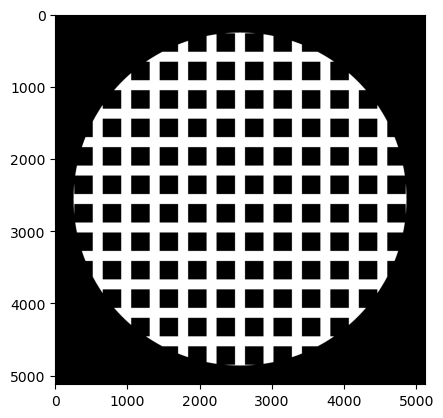

In [19]:
def generate_image(nx, ny, periods=6.5, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    image = (image>=1) * 1.
    image *= ((X**2 + Y**2) < radius**2) * 1.
    return image
    
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=6.5, threshold=0.45, radius=.9)
plt.imshow(image, cmap='gray');

In [20]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_grid-image'

output_filename = c.plot(z, image)
c.show(output_filename)

In [21]:
for threshold in np.linspace(0, 1, N_scan+2)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grid-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=6.5, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

threshold=0.100 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.100_8d2bd215.png' 
threshold=0.200 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.200_77983adc.png' 
threshold=0.300 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.300_6c41042b.png' 
threshold=0.400 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.400_3f94737a.png' 
threshold=0.500 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.500_4b46d07c.png' 
threshold=0.600 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.600_7b50993a.png' 
threshold=0.700 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.700_2b45fb8d.png' 
threshold=0.800 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.800_482f38a2.png' 
threshold=0.900 -> output_filename='2022-12-04_caustique/caustique_grid-image_threshold=0.900_9eadc0a4.png' 


In [22]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_grid-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_5.000_f2e276f8.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_5.946_88e37507.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_7.071_e6a377f2.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_8.409_b73f2d2d.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_10.000_bad80056.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_11.892_0a6a0f24.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_14.142_c51fe8ca.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_16.818_7ff66ffa.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_20.000_cafc69fb.png' 


In [23]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grid-image_{periods=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods, threshold=.2)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

periods=1.000 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=1.000_c4fdbbac.png' 
periods=1.334 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=1.334_14a50697.png' 
periods=1.778 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=1.778_5396e7d6.png' 
periods=2.371 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=2.371_858d2df0.png' 
periods=3.162 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=3.162_a1aa4ca2.png' 
periods=4.217 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=4.217_8dc19a47.png' 
periods=5.623 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=5.623_3b12195b.png' 
periods=7.499 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=7.499_f98cd101.png' 
periods=10.000 -> output_filename='2022-12-04_caustique/caustique_grid-image_periods=10.000_7618e656.png' 


## shining a hole image to the wave

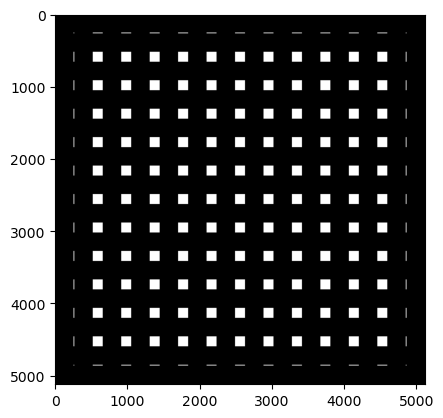

In [24]:
def generate_image(nx, ny, periods=6.5, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    image = 1. - (image<=1)
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=6.5, threshold=0.45, radius=.9)
plt.imshow(image, cmap='gray');

In [25]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_hole-image'

output_filename = c.plot(z, image)
c.show(output_filename)

In [26]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_hole-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_5.000_71413d18.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_5.946_30258f47.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_7.071_c2add569.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_8.409_1235c96f.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_10.000_a77a506f.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_11.892_c8e7e290.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_14.142_ec689f72.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_16.818_952cbc67.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_20.000_2e20fb69.png' 


In [27]:
for threshold in np.linspace(0, 1, N_scan+2)[1:-1]:
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_hole-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=6.5, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

threshold=0.100 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.100_b470651c.png' 
threshold=0.200 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.200_3c67ac7f.png' 
threshold=0.300 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.300_68d84d83.png' 
threshold=0.400 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.400_3f06b371.png' 
threshold=0.500 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.500_759dc85d.png' 
threshold=0.600 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.600_a8462617.png' 
threshold=0.700 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.700_8abec2bf.png' 
threshold=0.800 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.800_e288d5db.png' 
threshold=0.900 -> output_filename='2022-12-04_caustique/caustique_hole-image_threshold=0.900_921d5b0d.png' 


In [28]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_hole-image_{periods=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods, threshold=.2)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

periods=1.000 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=1.000_fb9755cf.png' 
periods=1.334 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=1.334_c83b9e8d.png' 
periods=1.778 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=1.778_4e76e4be.png' 
periods=2.371 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=2.371_05d5ceba.png' 
periods=3.162 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=3.162_45e3b091.png' 
periods=4.217 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=4.217_cf19c1fc.png' 
periods=5.623 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=5.623_a83342eb.png' 
periods=7.499 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=7.499_6fcf7633.png' 
periods=10.000 -> output_filename='2022-12-04_caustique/caustique_hole-image_periods=10.000_1618eb10.png' 


## shining a square image to the wave

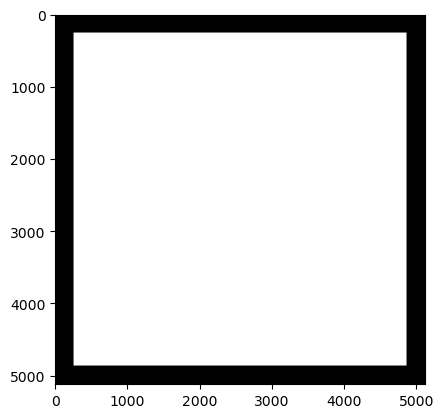

In [29]:
def generate_image(nx, ny,  radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=.9)
plt.imshow(image, cmap='gray');

In [30]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_square-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [31]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_hole-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_5.000_71413d18.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_5.946_30258f47.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_7.071_c2add569.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_8.409_1235c96f.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_10.000_a77a506f.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_11.892_c8e7e290.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_14.142_ec689f72.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_16.818_952cbc67.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_hole-image__H_20.000_2e20fb69.png' 


In [32]:
for radius in np.linspace(0, 1, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_square-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

radius=0.000 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.000_6213ba8b.png' 
radius=0.125 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.125_924d2a13.png' 
radius=0.250 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.250_6843b7b6.png' 
radius=0.375 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.375_e26e4061.png' 
radius=0.500 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.500_bfad2304.png' 
radius=0.625 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.625_2433fd23.png' 
radius=0.750 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.750_c2bd8665.png' 
radius=0.875 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=0.875_941e392a.png' 
radius=1.000 -> output_filename='2022-12-04_caustique/caustique_square-image_radius=1.000_f243a7b7.png' 


## shining a disk image to the wave

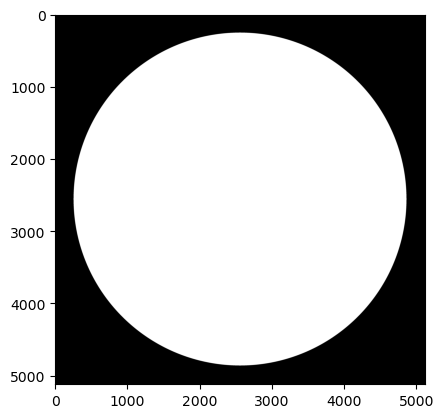

In [33]:
def generate_image(nx, ny, radius_in=0., radius_out=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = ((X**2 + Y**2) < radius_out**2) * ((X**2 + Y**2) > radius_in**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_out=.9)
plt.imshow(image, cmap='gray');

In [34]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_disk-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [35]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_disk-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_5.000_c202f9f8.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_5.946_a73755c7.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_7.071_ac193d4f.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_8.409_9246c3a1.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_10.000_5de8bbad.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_11.892_eb9c7b4b.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_14.142_e455da29.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_16.818_2b1b5155.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_20.000_b57406c0.png' 


In [36]:
for radius_out in np.linspace(0, 1, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_disk-image_{radius_out=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_out=radius_out)
    output_filename = c.plot(z, image)
    print(f'{radius_out:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

0.000 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.000_cf3a0e0c.png' 
0.125 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.125_4f41df58.png' 
0.250 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.250_f1c134e9.png' 
0.375 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.375_4a55ee50.png' 
0.500 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.500_c55b0239.png' 
0.625 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.625_db71015c.png' 
0.750 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.750_af582138.png' 
0.875 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.875_538178ac.png' 
1.000 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=1.000_d5289117.png' 


In [37]:
for radius_in in np.linspace(0, .9, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_disk-image_{radius_in=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_in=radius_in)
    output_filename = c.plot(z, image)
    print(f'{radius_in=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

radius_in=0.000 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.000_0437aff3.png' 
radius_in=0.113 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.113_a8d6c456.png' 
radius_in=0.225 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.225_04fc0e45.png' 
radius_in=0.338 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.338_e2976ed1.png' 
radius_in=0.450 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.450_d4149bbe.png' 
radius_in=0.562 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.562_34b17c7f.png' 
radius_in=0.675 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.675_be7344dd.png' 
radius_in=0.787 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.787_2c451641.png' 
radius_in=0.900 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.900_98eca1df.png' 


## shining a disk image to the wave

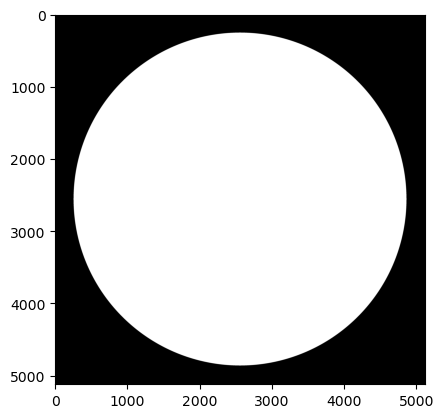

In [38]:
def generate_image(nx, ny, radius_in=0., radius_out=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = ((X**2 + Y**2) < radius_out**2) * ((X**2 + Y**2) > radius_in**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_out=.9)
plt.imshow(image, cmap='gray');

In [39]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_disk-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [40]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_disk-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_5.000_c202f9f8.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_5.946_a73755c7.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_7.071_ac193d4f.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_8.409_9246c3a1.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_10.000_5de8bbad.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_11.892_eb9c7b4b.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_14.142_e455da29.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_16.818_2b1b5155.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_disk-image__H_20.000_b57406c0.png' 


In [41]:
for radius_out in np.linspace(0, 1, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_disk-image_{radius_out=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_out=radius_out)
    output_filename = c.plot(z, image)
    print(f'{radius_out:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

0.000 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.000_cf3a0e0c.png' 
0.125 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.125_4f41df58.png' 
0.250 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.250_f1c134e9.png' 
0.375 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.375_4a55ee50.png' 
0.500 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.500_c55b0239.png' 
0.625 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.625_db71015c.png' 
0.750 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.750_af582138.png' 
0.875 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=0.875_538178ac.png' 
1.000 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_out=1.000_d5289117.png' 


In [42]:
for radius_in in np.linspace(0, .9, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_disk-image_{radius_in=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius_in=radius_in)
    output_filename = c.plot(z, image)
    print(f'{radius_in=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

radius_in=0.000 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.000_0437aff3.png' 
radius_in=0.113 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.113_a8d6c456.png' 
radius_in=0.225 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.225_04fc0e45.png' 
radius_in=0.338 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.338_e2976ed1.png' 
radius_in=0.450 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.450_d4149bbe.png' 
radius_in=0.562 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.562_34b17c7f.png' 
radius_in=0.675 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.675_be7344dd.png' 
radius_in=0.787 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.787_2c451641.png' 
radius_in=0.900 -> output_filename='2022-12-04_caustique/caustique_disk-image_radius_in=0.900_98eca1df.png' 


## shining a grating image to the wave

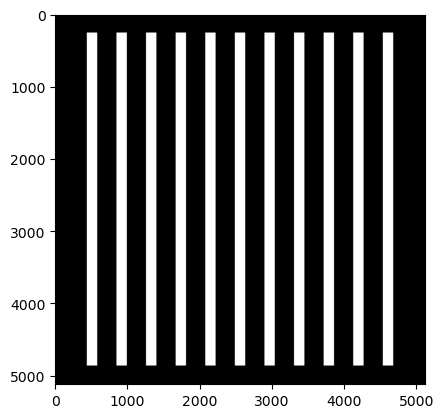

In [43]:
def generate_image(nx, ny, periods=6.25, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    # image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image = (image>=1) * 1.
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
plt.imshow(image, cmap='gray');

In [44]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_grating-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [45]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_grating-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_5.000_194e050e.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_5.946_036b7d0e.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_7.071_206b695a.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_8.409_b43a3010.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_10.000_119c016f.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_11.892_35dd4e0d.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_14.142_ace7c19d.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_16.818_96a4358b.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_20.000_891a1ca0.png' 


In [46]:
for threshold in np.linspace(0, 1, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grating-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

0.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.000_228763c8.png' 
0.125 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.125_e00926c3.png' 
0.250 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.250_5b7425cd.png' 
0.375 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.375_9f6142b7.png' 
0.500 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.500_217b0e3e.png' 
0.625 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.625_5feb4161.png' 
0.750 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.750_14f35359.png' 
0.875 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.875_ee68c119.png' 
1.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=1.000_4f2f19a2.png' 


In [47]:
for radius in np.linspace(0, .9, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grating-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

radius=0.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.000_560fa4dd.png' 
radius=0.113 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.113_81ef0b60.png' 
radius=0.225 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.225_1f630f59.png' 
radius=0.338 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.338_a32ec3f7.png' 
radius=0.450 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.450_ec5727de.png' 
radius=0.562 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.562_b8920d49.png' 
radius=0.675 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.675_dac17f4c.png' 
radius=0.787 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.787_fa664b7f.png' 
radius=0.900 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.900_43cba270.png' 


In [48]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grating-image_{periods=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

periods=1.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=1.000_733df210.png' 
periods=1.334 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=1.334_880144e6.png' 
periods=1.778 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=1.778_cec92c53.png' 
periods=2.371 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=2.371_1bddad5d.png' 
periods=3.162 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=3.162_937fc741.png' 
periods=4.217 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=4.217_be174b6c.png' 
periods=5.623 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=5.623_b93ac178.png' 
periods=7.499 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=7.499_b2fc52a7.png' 
periods=10.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=10.000_3d589cbc.png' 


## shining a grating image to the wave

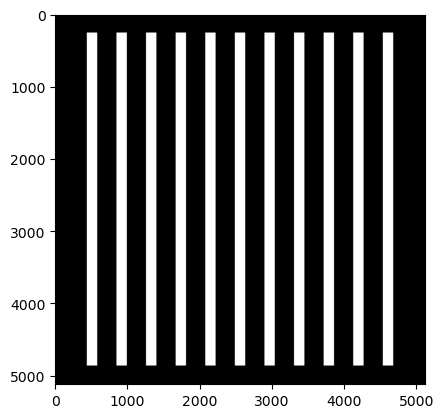

In [49]:
def generate_image(nx, ny, periods=6.25, threshold=0.45, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image = (np.cos(2*np.pi*X*periods) > threshold)*1.
    # image += (np.cos(2*np.pi*Y*periods) > threshold)*1.
    # image = (image>=1) * 1.
    image *= (X**2 < radius**2) * (Y**2 < radius**2) * 1.
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
plt.imshow(image, cmap='gray');

In [50]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_grating-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [51]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_grating-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_5.000_194e050e.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_5.946_036b7d0e.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_7.071_206b695a.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_8.409_b43a3010.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_10.000_119c016f.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_11.892_35dd4e0d.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_14.142_ace7c19d.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_16.818_96a4358b.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_grating-image__H_20.000_891a1ca0.png' 


In [52]:
for threshold in np.linspace(0, 1, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grating-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

0.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.000_228763c8.png' 
0.125 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.125_e00926c3.png' 
0.250 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.250_5b7425cd.png' 
0.375 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.375_9f6142b7.png' 
0.500 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.500_217b0e3e.png' 
0.625 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.625_5feb4161.png' 
0.750 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.750_14f35359.png' 
0.875 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=0.875_ee68c119.png' 
1.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_threshold=1.000_4f2f19a2.png' 


In [53]:
for radius in np.linspace(0, .9, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grating-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

radius=0.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.000_560fa4dd.png' 
radius=0.113 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.113_81ef0b60.png' 
radius=0.225 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.225_1f630f59.png' 
radius=0.338 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.338_a32ec3f7.png' 
radius=0.450 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.450_ec5727de.png' 
radius=0.562 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.562_b8920d49.png' 
radius=0.675 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.675_dac17f4c.png' 
radius=0.787 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.787_fa664b7f.png' 
radius=0.900 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.900_43cba270.png' 


In [54]:
for periods in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grating-image_{periods=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, periods=periods)
    output_filename = c.plot(z, image)
    print(f'{periods=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

periods=1.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=1.000_733df210.png' 
periods=1.334 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=1.334_880144e6.png' 
periods=1.778 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=1.778_cec92c53.png' 
periods=2.371 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=2.371_1bddad5d.png' 
periods=3.162 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=3.162_937fc741.png' 
periods=4.217 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=4.217_be174b6c.png' 
periods=5.623 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=5.623_b93ac178.png' 
periods=7.499 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=7.499_b2fc52a7.png' 
periods=10.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_periods=10.000_3d589cbc.png' 


## shining a bigrating image to the wave

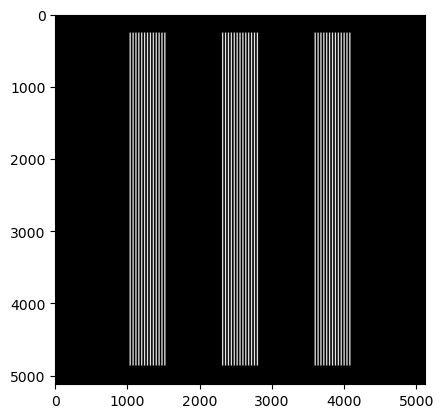

In [55]:
def generate_image(nx, ny, period1=2, period2=64, threshold=0.3, radius=.9):
    X, Y = np.meshgrid(np.linspace(-1, 1, nx, endpoint=True), np.linspace(-1, 1, ny, endpoint=True))
    image  = (np.cos(2*np.pi*X*period1) > threshold) * 1.
    image *= np.cos(2*np.pi*X*period2) > threshold
    image *= (X**2 < radius**2) * (Y**2 < radius**2)
    return image
image = generate_image(nx=c.opt.nx, ny=c.opt.ny)
plt.imshow(image, cmap='gray');

In [56]:
c = Caustique(init())
c.opt.tag = f'{c.opt.tag}_bigrating-image'
output_filename = c.plot(z, image)
c.show(output_filename)

In [57]:
for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    c = Caustique(opt)
    c.opt.H = H_
    c.opt.tag = f'{c.opt.tag}_grid-image__H_{H_:.3f}'
    
    output_filename = c.plot(z, image)
    print(f'H = {H_:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

H = 5.000 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_5.000_f2e276f8.png' 
H = 5.946 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_5.946_88e37507.png' 
H = 7.071 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_7.071_e6a377f2.png' 
H = 8.409 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_8.409_b73f2d2d.png' 
H = 10.000 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_10.000_bad80056.png' 
H = 11.892 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_11.892_0a6a0f24.png' 
H = 14.142 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_14.142_c51fe8ca.png' 
H = 16.818 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_16.818_7ff66ffa.png' 
H = 20.000 -> output_filename='2022-12-04_caustique/caustique_grid-image__H_20.000_cafc69fb.png' 


In [58]:
for threshold in np.linspace(0, 1, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_bigrating-image_{threshold=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, threshold=threshold)
    output_filename = c.plot(z, image)
    print(f'{threshold:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

0.000 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.000_b2d1c0fe.png' 
0.125 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.125_ede44788.png' 
0.250 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.250_adc49acc.png' 
0.375 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.375_519df562.png' 
0.500 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.500_64568ea7.png' 
0.625 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.625_1ca58bf2.png' 
0.750 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.750_3e931565.png' 
0.875 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=0.875_9d6eb8b6.png' 
1.000 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_threshold=1.000_7e33b86a.png' 


In [59]:
for radius in np.linspace(0, .9, N_scan):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_grating-image_{radius=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, radius=radius)
    output_filename = c.plot(z, image)
    print(f'{radius=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

radius=0.000 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.000_560fa4dd.png' 
radius=0.113 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.113_81ef0b60.png' 
radius=0.225 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.225_1f630f59.png' 
radius=0.338 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.338_a32ec3f7.png' 
radius=0.450 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.450_ec5727de.png' 
radius=0.562 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.562_b8920d49.png' 
radius=0.675 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.675_dac17f4c.png' 
radius=0.787 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.787_fa664b7f.png' 
radius=0.900 -> output_filename='2022-12-04_caustique/caustique_grating-image_radius=0.900_43cba270.png' 


In [60]:
for period1 in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_bigrating-image_{period1=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, period1=period1)
    output_filename = c.plot(z, image)
    print(f'{period1=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

period1=1.000 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=1.000_a176ad36.png' 
period1=1.334 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=1.334_2123daac.png' 
period1=1.778 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=1.778_9960217f.png' 
period1=2.371 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=2.371_57e33c9e.png' 
period1=3.162 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=3.162_a6cd3e1e.png' 
period1=4.217 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=4.217_52028343.png' 
period1=5.623 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=5.623_d2c37fc9.png' 
period1=7.499 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=7.499_72544e89.png' 
period1=10.000 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period1=10.000_5a5427b5.png' 


In [61]:
for period2 in np.logspace(0, 1, N_scan, base=10):
    opt = init()
    c = Caustique(opt)

    c.opt.tag = f'{c.opt.tag}_bigrating-image_{period2=:.3f}'
    image = generate_image(nx=c.opt.nx, ny=c.opt.ny, period2=period2)
    output_filename = c.plot(z, image)
    print(f'{period2=:.3f} -> {output_filename=} ')
    if c.opt.do_display: c.show(output_filename)

period2=1.000 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=1.000_2ebd423d.png' 
period2=1.334 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=1.334_f5e5ff12.png' 
period2=1.778 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=1.778_82b5b4ca.png' 
period2=2.371 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=2.371_113894f7.png' 
period2=3.162 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=3.162_959e3e59.png' 
period2=4.217 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=4.217_ec9efb32.png' 
period2=5.623 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=5.623_c5fca0f9.png' 
period2=7.499 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=7.499_e6d2ddb3.png' 
period2=10.000 -> output_filename='2022-12-04_caustique/caustique_bigrating-image_period2=10.000_7a2bdec2.png' 
